In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib import patches
from numpy import random
from matplotlib import cm
import copy
import time
from tqdm import tqdm

Let us consider the case where we have 2 parameters $\theta_1$ and $\theta_2$. Prior for $\theta_1$ and $\theta_2$ be $\Pi(\theta_1)$ and $\Pi(\theta_2)$, respectively, which are given by:

$$\Pi(\theta_1) = U[-5, 5] \quad \quad \Pi(\theta_2) = U[-5, 5]$$

And likelihood function be $$\mathcal{L}(d|\vec{\theta}) \equiv \mathcal{L}(\vec{\theta}) = \mathcal{N}(\vec{\theta}|\mu = 0, \Sigma = I_{2\times2})$$

Text(0, 0.5, '$\\theta_2$')

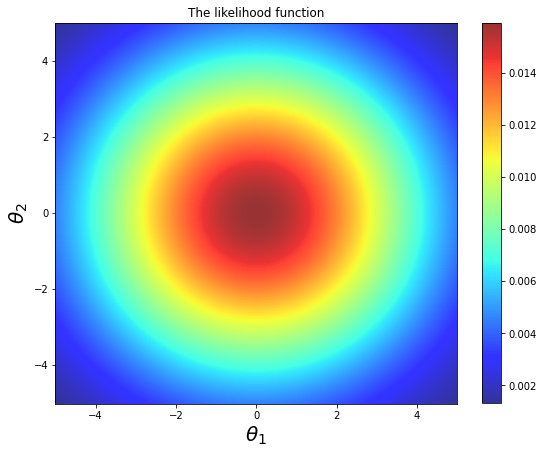

In [2]:
mean = np.array([0, 0])
Σ = 10*np.identity(2)

x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))

L = st.multivariate_normal(mean, Σ)

plt.figure(figsize = (9, 7))
plt.title("The likelihood function")
plt.pcolormesh(x, y, L.pdf(pos), cmap = cm.jet, alpha = 0.8)
plt.colorbar()
plt.xlabel(r'$\theta_1$', fontsize = '20')
plt.ylabel(r'$\theta_2$', fontsize = '20')

In [3]:
def from_prior():                               # Sampling the prior.
    
    θ1 = -5 + 10 * random.rand()
    θ2 = -5 + 10 * random.rand()

    return np.array([θ1, θ2])

def likelihood(params):                         #Gaussian likelihood.
    theta1, theta2 = params[0], params[1]
    return L.pdf(params)

In [4]:
random.seed(7)
# nLive = int(input("Enter number of live points."))
nLive = 200
steps = 2000

livePoints = np.empty((nLive, 2))         # Live points.
lklhood = np.empty(nLive)                 # Likelihood values of the live points.
discardedPoints = np.empty((steps, 2))    # discarded point at each step is appended here.
X = np.array([1])                         # The prior mass.
Z = np.array([0])                         # The evidence.
width = np.empty(steps)                   # difference b/w consecutive X values.
lklhoodDiscarded = np.empty(steps)        # Likelihood of the discarded points.

statisticalX = np.empty(steps)            # statistical value of X.
statisticalX[0] = 1 
statisticalWidth = np.empty(steps)
statisticalZ = np.array([0])

for i in range(0, nLive): 
    x = from_prior()
    livePoints[i,:] = x                   # Live points are sampled.
    lklhood[i] = likelihood(x)            # Likelihood values of the live points.

Text(0, 0.5, '$\\theta_2$')

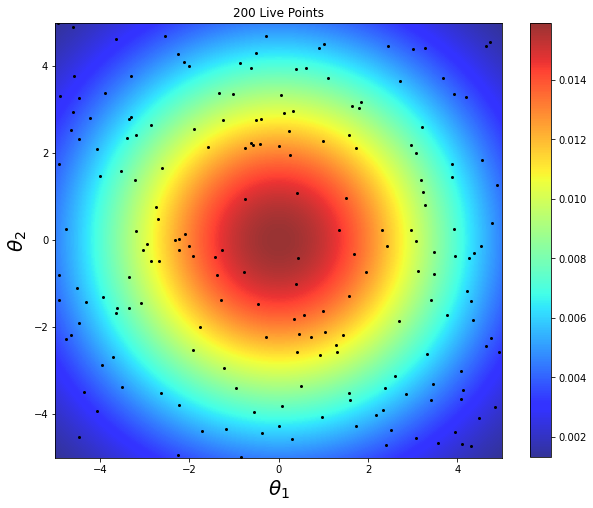

In [5]:
x, y = np.mgrid[-5:5:.01, -5:5:.01]
pos = np.dstack((x, y))

plt.figure(figsize = (10, 8))
plt.pcolormesh(x, y, L.pdf(pos), cmap = cm.jet, alpha = 0.8)
plt.colorbar()
plt.scatter(livePoints[:, 0], livePoints[:, 1], s = 4, c = 'k')
plt.title(f'{nLive} Live Points')
plt.xlabel(r'$\theta_1$', fontsize = 20)
plt.ylabel(r'$\theta_2$', fontsize = 20)

In [6]:
start = time.time()
keep = np.zeros((steps, 6))               # keep stores: [theta1, theta2, X, w, L, Z]

for i in tqdm(range(steps)):
    
    worstIndex = np.argmin(lklhood)
    discardedPoints[i] = livePoints[worstIndex]
    lklhoodDiscarded[i] = lklhood[worstIndex]
    
    radius = np.linalg.norm(livePoints[worstIndex])
    priorMass = np.pi * radius**2/100.
    X = np.append(X, priorMass)
    
    width[i] = X[i] - X[i+1]
    Z = np.append(Z, Z[i] + lklhoodDiscarded[i] * width[i])
    
    
    threshold = copy.deepcopy(lklhood[worstIndex])
    
    statisticalX[i] = np.exp(-i/nLive)
    
    statisticalWidth[i] = np.exp(-i/nLive) - np.exp(-(i+1)/nLive)
    statisticalZ = np.append(statisticalZ, statisticalZ[i] + lklhoodDiscarded[i] * statisticalWidth[i])
    
    keep[i, :2] = livePoints[worstIndex]
    keep[i, 2:6] = X[i+1], width[i], lklhoodDiscarded[i], Z[i+1]
    

    for j in range(10000):
        
        newPoint = from_prior()

        lklNewPoint = likelihood(newPoint)
            
        if (lklNewPoint >= threshold):
            
            livePoints[worstIndex] = newPoint
            lklhood[worstIndex] = lklNewPoint
            break 
            
end = time.time()
print(f'time taken: {(end-start)/60.} minutes')

100%|██████████| 2000/2000 [01:35<00:00, 20.93it/s] 

time taken: 1.5924670616785686 minutes


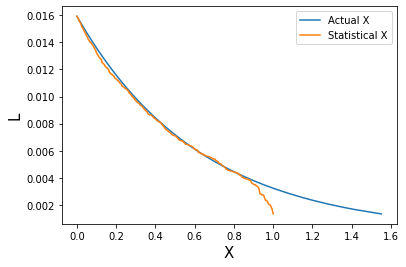

In [10]:
plt.plot(keep[:,2], keep[:, 4], label = 'Actual X')
plt.plot(statisticalX, keep[:, 4], label = 'Statistical X')
plt.xlabel('X', fontsize = 15)
plt.ylabel('L', fontsize = 15)
plt.legend()

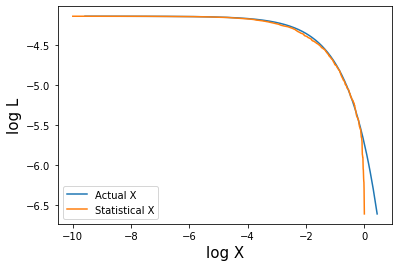

In [13]:
plt.plot(np.log(keep[:, 2]), np.log(keep[:, 4]), label = 'Actual X')
plt.plot(np.log(statisticalX), np.log(keep[:, 4]), label = 'Statistical X')
plt.xlabel('log X', fontsize = 15)
plt.ylabel('log L', fontsize = 15)
plt.legend()
plt.show()

Text(0, 0.5, '$\\theta_2$')

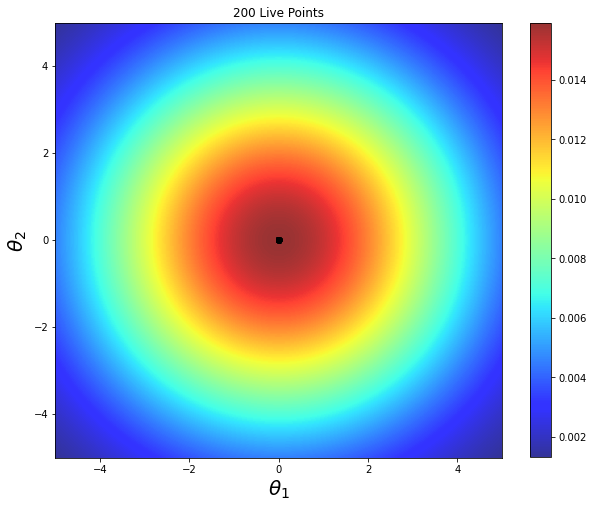

In [14]:
x, y = np.mgrid[-5:5:0.01, -5:5:0.01]
pos = np.dstack((x, y))

plt.figure(figsize = (10, 8))

plt.pcolormesh(x, y, L.pdf(pos), cmap = cm.jet, alpha = 0.8)
plt.colorbar()
plt.scatter(livePoints[:, 0], livePoints[:, 1], s = 4, c = 'k')
plt.title(f'{nLive} Live Points')
plt.xlabel(r'$\theta_1$', fontsize = 20)
plt.ylabel(r'$\theta_2$', fontsize = 20)

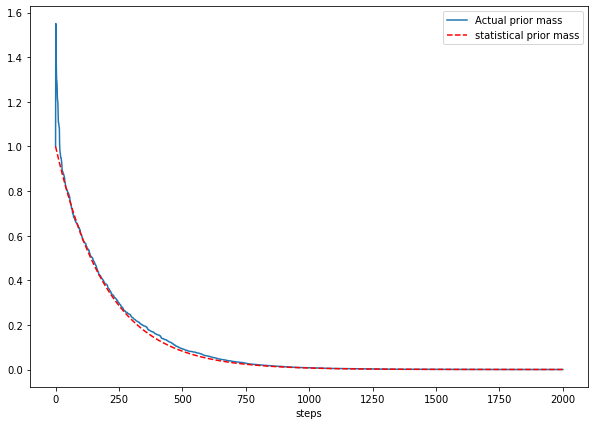

In [15]:
plt.figure(figsize = (10, 7))
plt.plot(X, label = 'Actual prior mass')
plt.plot(statisticalX, ls = '--', c = 'r', label = 'statistical prior mass')

# plt.xlim(20,500)
plt.xlabel('steps')
plt.legend()

In [16]:
print(f'Calculated evidence using actual X values: {Z[-1]}')
print(f'Calculated evidence using statistical X values: {statisticalZ[-1]}')

Calculated evidence using actual X values: 0.00849413459892167
Calculated evidence using statistical X values: 0.007756842383336091
